<a href="https://colab.research.google.com/github/AppuStriker/Classification-And-Segmentation-Of-Medical-Images-Using-Monai/blob/main/LiverSegmentation_with_MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading Dataset**

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'liver-tumor-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F767686%2F1327578%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240424%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240424T141436Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09dc83747e65a7e3871d049cf14b215819225d466a16cc4508a427c2653bae7493c7b27af9a258ae69a6996c606d33efbfce1d8c66b00d9c2b85ff728ca15cf745f3f0cbf442d3feff5da33ab8e75691a6aa1abce64568f867676753dff55b29bafdab5303de70765d819305089d43d63f029bbec16572137f8ed8b434838835f8c8d1b95f82faa66a0a0eec30a7124578693cab1f9bf70b4103790bbd44c0f6a51029aaf6ec2ff311c9ff6558eee12ddef614bd7d287f2488a60e03be228970f0eeeb3a30e8ecdb716810f4e96980d8b5ce71cb3dac3339d6c9b684cb704b4d5542289579138c6a31a2768ebb3a828eb3291f39747e7f9e436f491c1057d985,liver-tumor-segmentation-part-2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F769463%2F1327590%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240424%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240424T141436Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da836554d748aa86ab810aed6e64ca150fe61da822b335c08cdd3ad08d9e4df1707ae7180123add1ed052d3a161ab036b2c556aad22d6a63eb9d3671a85df243987c7ca44868f9e22cac61771f4af802de49946eff1d1b3e846636817b8e2312eef10a4e0325066bd5871a83834fef45c2d9b4ceb9a8b89bd3ee799449f15e098919d9def140cf871d3694771a66fd95a5563d792d897b29705ae8d71fdf8bfc1fec3da2091ba347f3e956addf888173845a7ba58cf705651c532a84742be7014723187284b4ca59cb2c3e588b4530be8550e04b18a6ec37b858ace49b6c15c0e1c0537019ea14fa2b80682e7e5de5111361d62aad8d5f92c5b20492b6d368040'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5193236906 bytes downloaded
Downloaded and uncompressed: liver-tumor-segmentation
[==================================================] 11600560826 bytes downloaded
Downloaded and uncompressed: liver-tumor-segmentation-part-2
Data source import complete.


# **install and import**

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.8 MB/s eta 0:00:00


In [ ]:

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ResizeWithPadOrCropd,
    SpatialCrop
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR,SwinUNETR,UNet

from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.networks.layers import Norm
import torch

print_config()

MONAI version: 1.4.dev2416
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d487995c8f685729ee5e1259f364034dab4811da
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.40.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

# **Data Preparation**

I want to upload the images to the cache for faster training. To achieve this, I have excluded images that contain more than 450 slices.

In [ ]:
import nibabel as nib
#image list
img_files=[os.path.join(path[0],file) for path in os.walk('/kaggle/input/')   for file in path[-1]  if 'pt' in path[0] if 'vol' in file]
len(img_files)
img_files_for_trainig=[]
for file in img_files:
    n1_img_sh = nib.load(file).header.get_data_shape()

    if     n1_img_sh[2]<450 :
        img_files_for_trainig.append(file)


In [ ]:
len(img_files_for_trainig)

67

In [ ]:
#segmentaim list
seg_path='/kaggle/input/liver-tumor-segmentation/segmentations/'


seg_files=[seg_path+'segmentation-'+file.split('-')[-1] for file in img_files_for_trainig]
print(img_files_for_trainig[2],seg_files[2])

/kaggle/input/liver-tumor-segmentation-part-2/volume_pt8/volume-118.nii /kaggle/input/liver-tumor-segmentation/segmentations/segmentation-118.nii


In [ ]:
#monai dataset need dictonary
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(img_files_for_trainig, seg_files)]
train_files, val_files,test_files = data_dicts[:-2], data_dicts[-2:-1],data_dicts[-1:]

In [ ]:
n1_img_sh = nib.load(data_dicts[0]['image'])#.header.get_data_shape()
data = n1_img_sh.get_fdata()

data.shape

(512, 512, 410)

# **Setup transforms for training and validation**



Here we use several transforms to augment the dataset:

    LoadImaged loads the liver CT images and labels from NIfTI format files.
    EnsureChannelFirstd ensures the original data to construct "channel first" shape.
    Spacingd adjusts the spacing by pixdim=(1.5, 1.5, 2.) based on the affine matrix.
    Orientationd unifies the data orientation based on the affine matrix.
    ScaleIntensityRanged extracts intensity range [-57, 164] and scales to [0, 1].
    CropForegroundd removes all zero borders to focus on the valid body area of the images and labels.
    
    RandCropByPosNegLabeld randomly crop patch samples from big image based on pos / neg ratio.

The image centers of negative samples must be in valid body area.

    RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
    EnsureTyped converts the numpy array to PyTorch Tensor for further steps.

In [ ]:
class ToLiver(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label[label==2]=1
        return {'image': image,
                'label': label}

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128, 32), #64
            pos=1,
            neg=1,
            num_samples=10,
            image_key="image",
            image_threshold=0,
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        )
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [ ]:
#create data set with the transform for the train and val


train_ds =CacheDataset(
    data=train_files,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)



Loading dataset: 100%|██████████| 65/65 [04:00<00:00,  3.71s/it]


In [ ]:
val_ds =Dataset(
    data=val_files,
    transform=val_transforms,
)

image shape: torch.Size([1, 512, 512, 122]), label shape: torch.Size([1, 512, 512, 122])


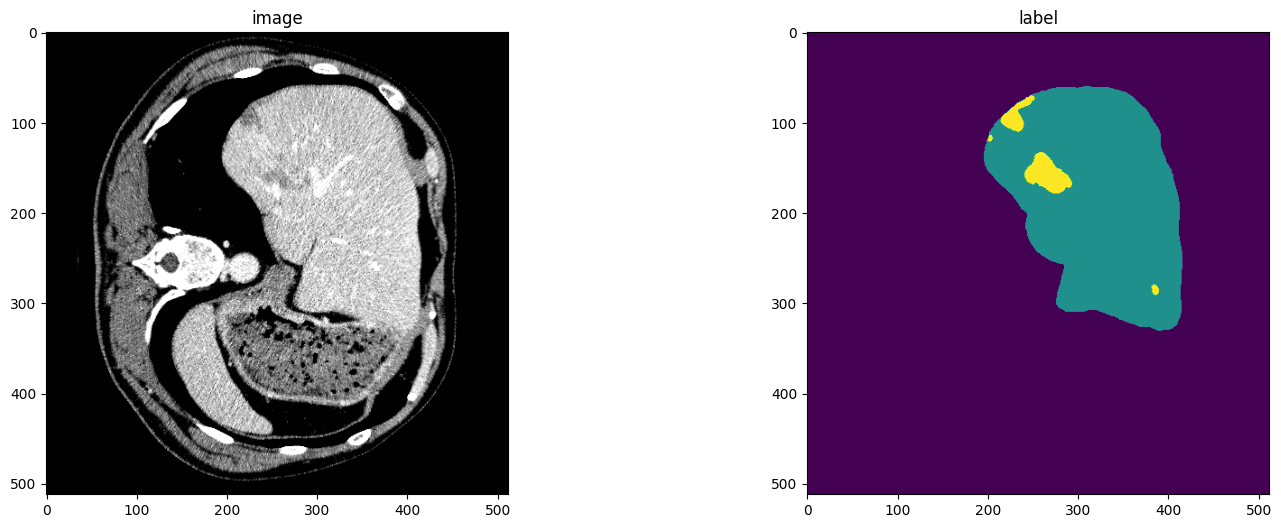

In [ ]:
img = val_ds[0]["image"]
label = val_ds[0]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[ 0,:, :,-30].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, -30].detach().cpu())
plt.show()

torch.Size([1, 512, 512, 122])
[[123, 160, 76], [41, 94, 67], [122, 97, 45], [83, 133, 46], [250, 256, 84], [94, 186, 72], [40, 149, 80], [275, 359, 78], [21, 177, 52], [73, 258, 45]]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


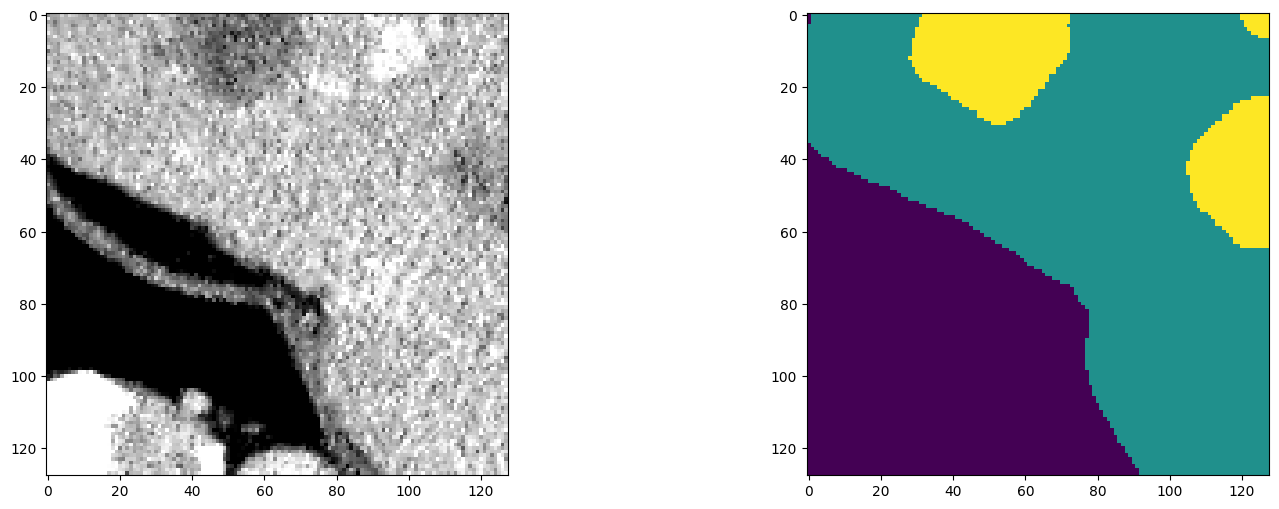

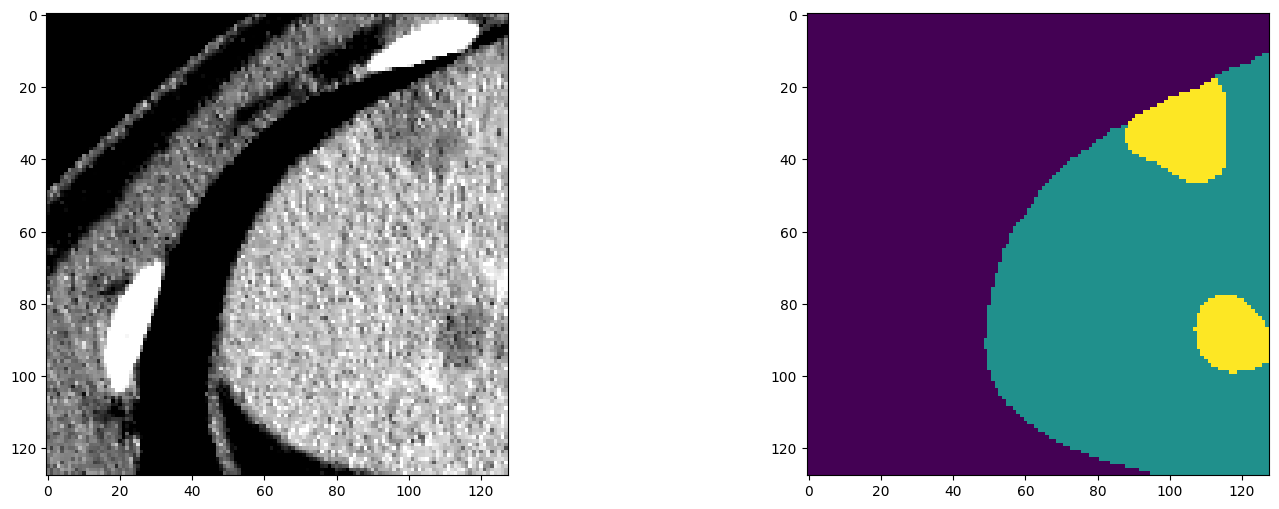

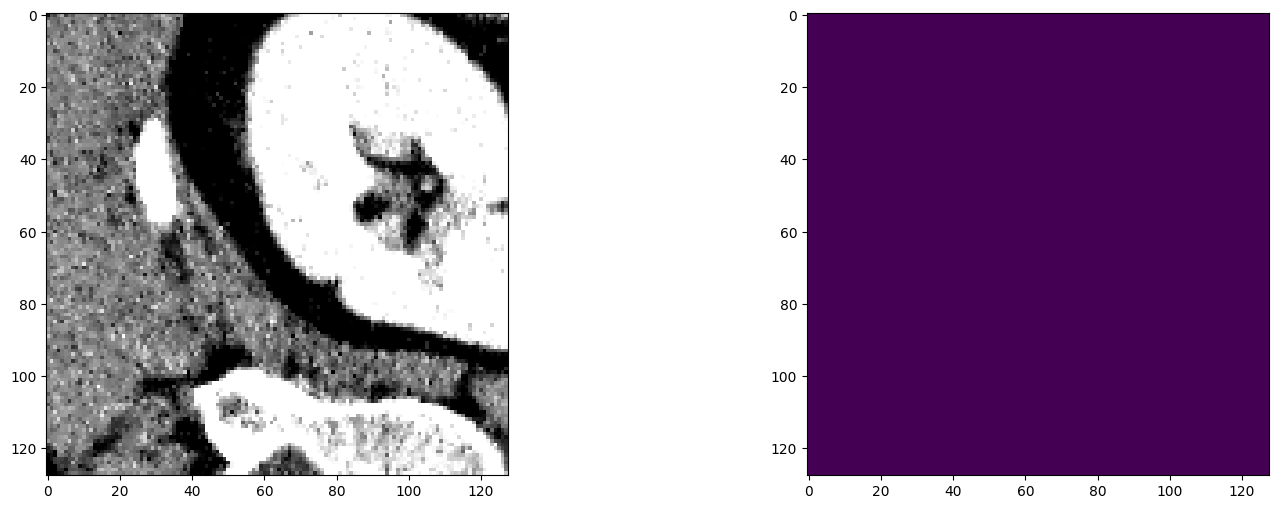

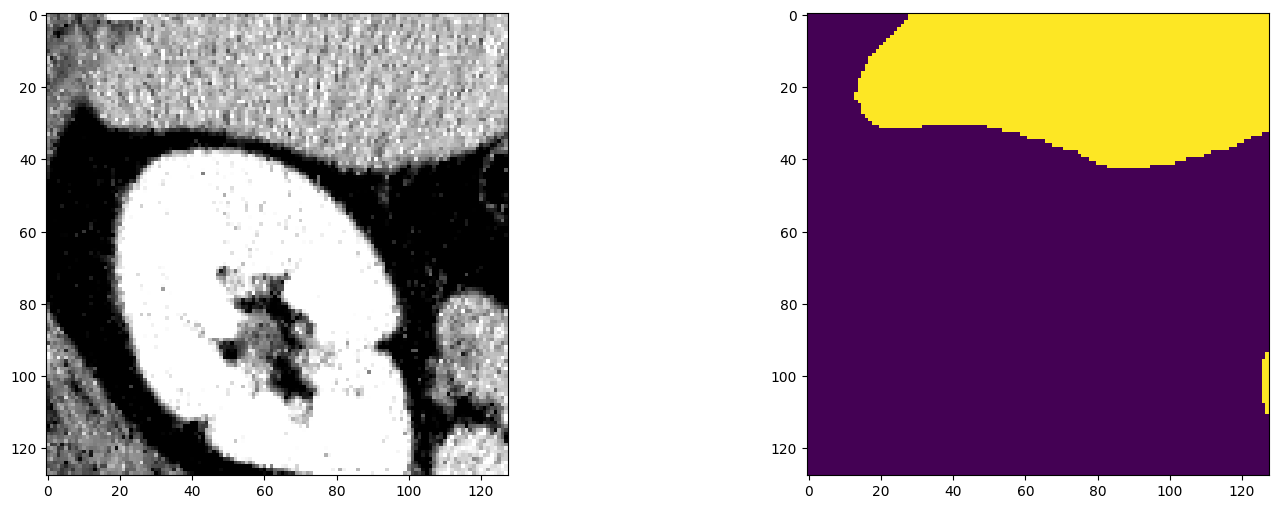

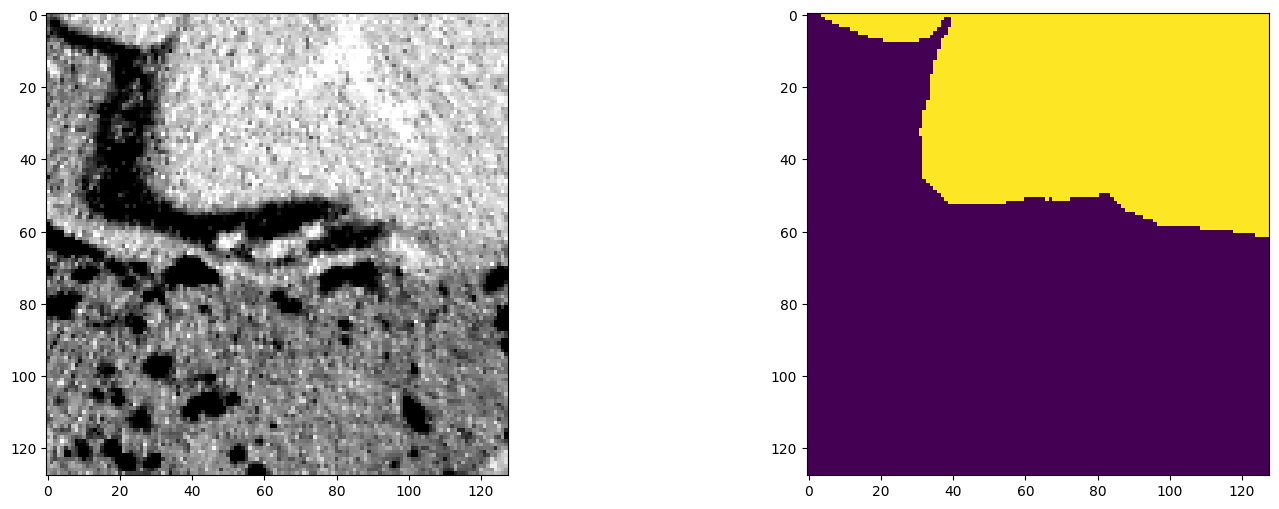

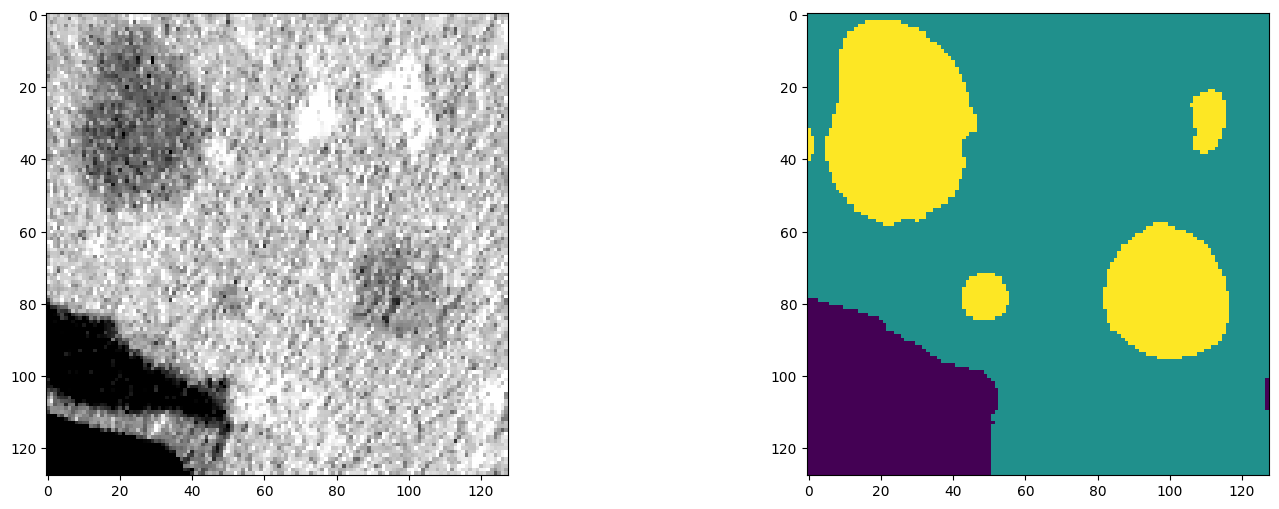

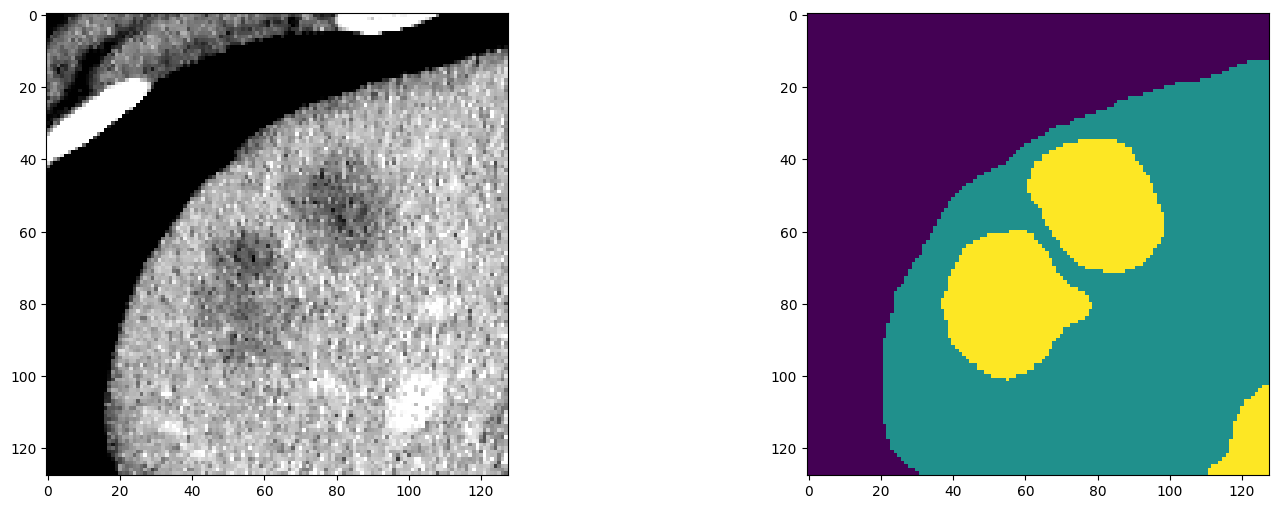

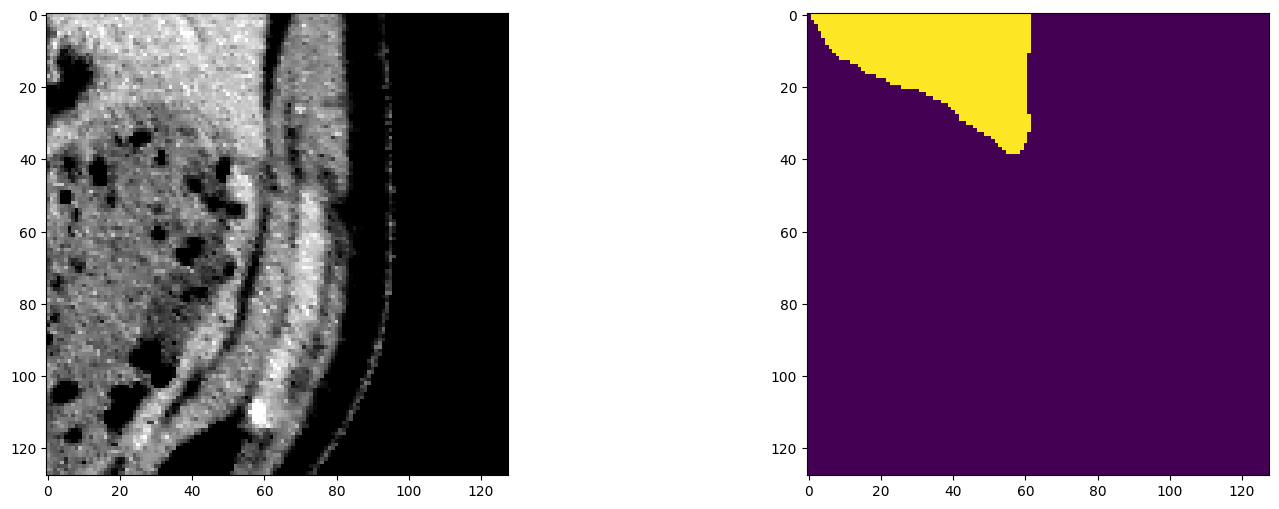

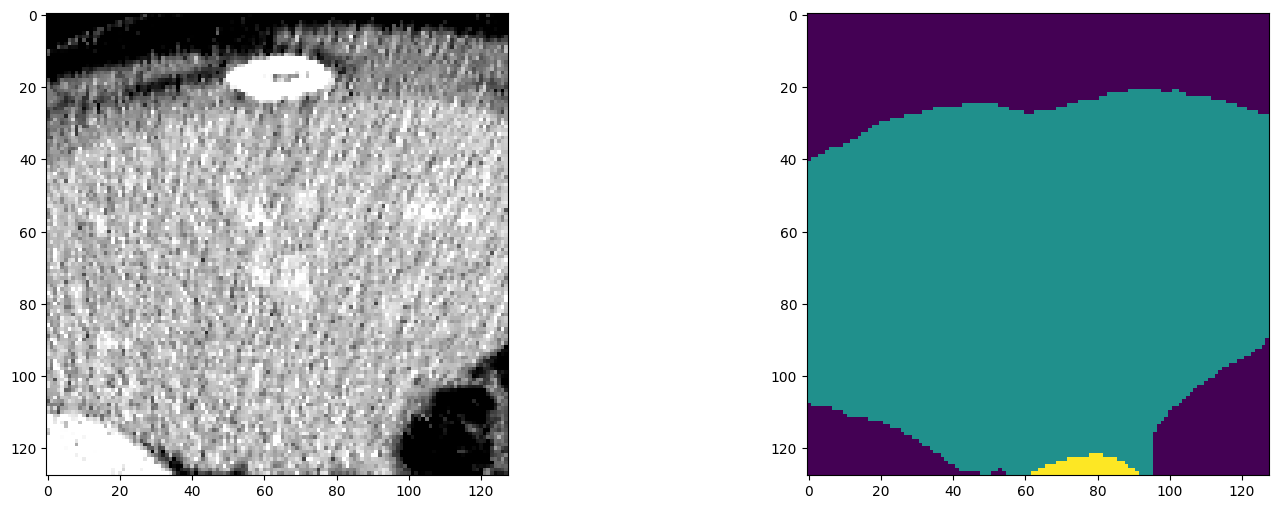

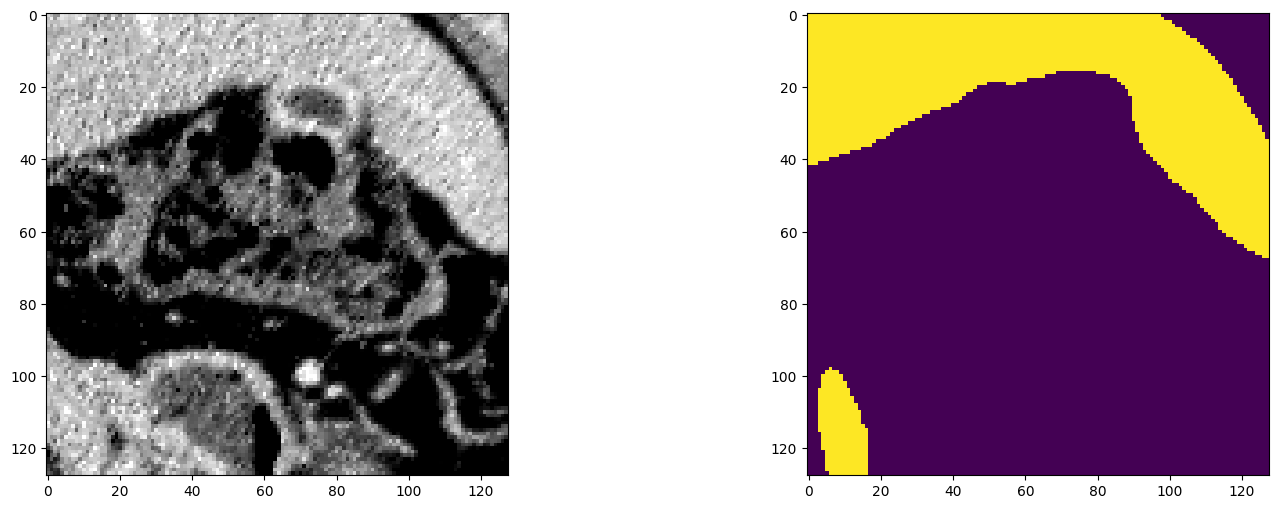

In [ ]:
import numpy as np
from numpy import random
from monai.data import PatchDataset, DataLoader, PatchIter
inds=[]
def Crop_label(label):
    r=[]
    b=0
    liver=0
    tumor=0

    if label.shape[0]==1:
        label=label[0]
    x,y,z=label.shape
    while(tumor<10):
        i = random.randint(x-128)
        j = random.randint(y-128)
        k = random.randint(z-32)


        unique_num=np.unique(label[i:i+128,j:j+128,k:k+32])
        if 2 in unique_num and tumor<10:
            tumor=tumor+1

            inds.append([i,j,k])
        '''
        elif 2 not in unique_num and 1 in unique_num and liver<5:
            liver=liver+1
            inds.append([i,j,k])
        elif 2 not in unique_num and 1 not in unique_num and b<0:
            b=b+1
            inds.append([i,j,k])
       '''


    return  inds



def Crop_img(img):
    r=[]
    b=0
    liver=0
    tumor=0

    if img.shape[0]==1:
        img=img[0]
    x,y,z=img.shape
    for ind in inds:
        i,j,k=ind

        r.append(img[i:i+128,j:j+128,k:k+32])


    return r

# imaabsge-level dataset
img = val_ds[0]["image"]

print(img.shape)
label = val_ds[0]["label"]

# image patch sampler
n_samples = 10
# patch-level intensity shifts
# construct the patch dataset

inds=Crop_label(label)

ds_l = PatchDataset(data=label,
                  patch_func=Crop_img,
                  samples_per_image=n_samples)
print(inds)
ds_i = PatchDataset(data=img,
                  patch_func=Crop_img,
                  samples_per_image=n_samples)



val_loader1=DataLoader(ds_i, batch_size=1, shuffle=False, num_workers=1)
val_loader2=DataLoader(ds_l, batch_size=1, shuffle=False, num_workers=1)

#y=DataLoader(label_ds, batch_size=1, shuffle=False, num_workers=2)

for i,item1 in enumerate(zip(val_loader1,val_loader2)):
    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(item1[0][0,:, :, 5].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(item1[1][0,:, :, 5].detach().cpu())
    plt.show()






# **Check data shape and visualize**

In [ ]:
from monai.networks.nets import TopologyInstance
from  monai.networks.nets import TopologySearch
from monai.networks.nets import AHNet,UNet
root_dir='/kaggle/working'
from monai.apps import load_from_mmar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model=AHNet(layers=(2, 2,2,2), spatial_dims=3, in_channels=1, out_channels=3
                                , psp_block_num=1, upsample_mode='transpose', pretrained=True, progress=True).to(device)

#model=VNet(spatial_dims=3, in_channels=1, out_channels=3).to(device)
'''
arch_mode=torch.load('/kaggle/input/search-code/search_code_18590.pt')
dints_space=TopologyInstance(
     channel_mul=1.0,
      num_blocks=12,
     num_depths=4, spatial_dims=3, act_name='RELU',
      use_downsample=True,
    arch_code=[arch_mode['arch_code_a'],arch_mode['arch_code_c']]).to(device)

model = DiNTS(dints_space, 1, 3, act_name='RELU',
 #model               spatial_dims=3, use_downsample=True,
                node_a= torch.from_numpy(arch_mode['node_a'])).to(device)



model =UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels= (8,16,32,64),
    strides=(2,2,2),
).to(device)

'''
#model=BasicUNetPlusPlus(spatial_dims=3, in_channels=1, out_channels=3).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [ ]:

#val_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)
test_ds =Dataset(
    data=test_files,
    transform=test_transforms,
)

**Model Training**

In [ ]:
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

def validation(epoch_iterator_val):
    model.eval()
    val_labels_convert=[]
    val_outputs_convert=[]
    with torch.no_grad():
        for step,batch in enumerate(zip(val_loader1,val_loader2)):
            val_inputs,val_labels=batch
            val_inputs=val_inputs[None,:,:,:,:].cuda()
            val_labels=val_labels[ None,:, :,:,:].cuda()
            val_outputs = model(val_inputs)
            val_labels_convert.append(post_label(decollate_batch(val_labels)[0])[0])
            val_outputs_convert.append(post_pred(decollate_batch(val_outputs)[0])[0])
        dice_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    #model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader1, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                        "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                    )
            else:
                    print(
                        "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                            dice_val_best, dice_val
                        )
                    )
    global_step += 1
    return global_step, dice_val_best, global_step_best

max_iterations = 20
eval_num = 50
'''
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
'''
#m''''''odel.load_state_dict(torch.load('/kaggle/input/model-liver2/best_metric_model.pth'))
#model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
while True:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

Validate (X / X Steps) (dice=X.X):   0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training (20 / 20 Steps) (loss=0.71771):   2%|▏         | 1/65 [00:05<06:06,  5.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7574206590652466 Current Avg. Dice: 0.7574206590652466


Training (20 / 20 Steps) (loss=1.15990):   2%|▏         | 1/65 [00:06<06:06,  5.73s/it]

Training (20 / 20 Steps) (loss=1.15990):   3%|▎         | 2/65 [00:10<05:32,  5.28s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8089626431465149 Current Avg. Dice: 0.8089626431465149


Training (20 / 20 Steps) (loss=1.34278):   5%|▍         | 3/65 [00:15<05:17,  5.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8089626431465149 Current Avg. Dice: 0.6771009564399719


Training (20 / 20 Steps) (loss=20.74572):   5%|▍         | 3/65 [00:16<05:17,  5.11s/it]

Training (20 / 20 Steps) (loss=20.74572):   6%|▌         | 4/65 [00:20<05:12,  5.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.816369891166687 Current Avg. Dice: 0.816369891166687


Training (20 / 20 Steps) (loss=0.99662):   8%|▊         | 5/65 [00:25<05:04,  5.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8384418487548828 Current Avg. Dice: 0.8384418487548828


Training (20 / 20 Steps) (loss=1.02871):   8%|▊         | 5/65 [00:26<05:04,  5.07s/it]

Training (20 / 20 Steps) (loss=1.02871):   9%|▉         | 6/65 [00:30<04:52,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8384418487548828 Current Avg. Dice: 0.7728084921836853


Training (20 / 20 Steps) (loss=1.20454):  11%|█         | 7/65 [00:35<04:53,  5.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8421422243118286 Current Avg. Dice: 0.8421422243118286


Training (20 / 20 Steps) (loss=1.78507):  11%|█         | 7/65 [00:36<04:53,  5.07s/it]

Training (20 / 20 Steps) (loss=1.78507):  12%|█▏        | 8/65 [00:40<04:39,  4.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8421422243118286 Current Avg. Dice: 0.6194131970405579


Training (20 / 20 Steps) (loss=2.51289):  14%|█▍        | 9/65 [00:45<04:35,  4.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.85236656665802 Current Avg. Dice: 0.85236656665802


Training (20 / 20 Steps) (loss=0.97016):  14%|█▍        | 9/65 [00:46<04:35,  4.91s/it]

Training (20 / 20 Steps) (loss=0.97016):  15%|█▌        | 10/65 [00:49<04:26,  4.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.85236656665802 Current Avg. Dice: 0.8180345296859741


Training (20 / 20 Steps) (loss=1.20388):  17%|█▋        | 11/65 [00:55<04:26,  4.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.85236656665802 Current Avg. Dice: 0.7410016059875488


Training (20 / 20 Steps) (loss=1.78475):  17%|█▋        | 11/65 [00:56<04:26,  4.93s/it]

Training (20 / 20 Steps) (loss=1.78475):  18%|█▊        | 12/65 [00:59<04:13,  4.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.85236656665802 Current Avg. Dice: 0.842873215675354


Training (20 / 20 Steps) (loss=1.11581):  20%|██        | 13/65 [01:04<04:13,  4.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8591518402099609 Current Avg. Dice: 0.8591518402099609


Training (20 / 20 Steps) (loss=1.22843):  20%|██        | 13/65 [01:06<04:13,  4.87s/it]

Training (20 / 20 Steps) (loss=1.22843):  22%|██▏       | 14/65 [01:09<04:10,  4.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8591518402099609 Current Avg. Dice: 0.8221251368522644


Training (20 / 20 Steps) (loss=1.03340):  23%|██▎       | 15/65 [01:14<04:03,  4.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8591518402099609 Current Avg. Dice: 0.8383156061172485


Training (20 / 20 Steps) (loss=0.98111):  23%|██▎       | 15/65 [01:15<04:03,  4.86s/it]

Training (20 / 20 Steps) (loss=0.98111):  25%|██▍       | 16/65 [01:19<03:57,  4.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8591518402099609 Current Avg. Dice: 0.836408257484436


Training (20 / 20 Steps) (loss=0.94987):  26%|██▌       | 17/65 [01:23<03:49,  4.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8591518402099609 Current Avg. Dice: 0.8521000146865845


Training (20 / 20 Steps) (loss=1.03587):  26%|██▌       | 17/65 [01:24<03:49,  4.78s/it]

Training (20 / 20 Steps) (loss=1.03587):  28%|██▊       | 18/65 [01:28<03:47,  4.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8684829473495483


Training (20 / 20 Steps) (loss=1.02303):  29%|██▉       | 19/65 [01:33<03:38,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8581792116165161


Training (20 / 20 Steps) (loss=1.17680):  29%|██▉       | 19/65 [01:34<03:38,  4.74s/it]

Training (20 / 20 Steps) (loss=1.17680):  31%|███       | 20/65 [01:37<03:31,  4.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8406587839126587


Training (20 / 20 Steps) (loss=1.06367):  32%|███▏      | 21/65 [01:42<03:28,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8411567807197571


Training (20 / 20 Steps) (loss=1.08917):  32%|███▏      | 21/65 [01:44<03:28,  4.74s/it]

Training (20 / 20 Steps) (loss=1.08917):  34%|███▍      | 22/65 [01:47<03:28,  4.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8403615951538086


Training (20 / 20 Steps) (loss=1.13255):  35%|███▌      | 23/65 [01:52<03:21,  4.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8432974815368652


Training (20 / 20 Steps) (loss=1.06302):  35%|███▌      | 23/65 [01:54<03:21,  4.80s/it]

Training (20 / 20 Steps) (loss=1.06302):  37%|███▋      | 24/65 [01:57<03:17,  4.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8474084734916687


Training (20 / 20 Steps) (loss=2.43424):  38%|███▊      | 25/65 [02:02<03:11,  4.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8035039901733398


Training (20 / 20 Steps) (loss=1.22107):  38%|███▊      | 25/65 [02:03<03:11,  4.79s/it]

Training (20 / 20 Steps) (loss=1.22107):  40%|████      | 26/65 [02:06<03:04,  4.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8142390251159668


Training (20 / 20 Steps) (loss=1.53861):  42%|████▏     | 27/65 [02:11<02:59,  4.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8302075266838074


Training (20 / 20 Steps) (loss=1.23243):  42%|████▏     | 27/65 [02:12<02:59,  4.72s/it]

Training (20 / 20 Steps) (loss=1.23243):  43%|████▎     | 28/65 [02:16<02:56,  4.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8326174020767212


Training (20 / 20 Steps) (loss=1.37679):  45%|████▍     | 29/65 [02:21<02:53,  4.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8369783163070679


Training (20 / 20 Steps) (loss=2.30778):  45%|████▍     | 29/65 [02:22<02:53,  4.81s/it]

Training (20 / 20 Steps) (loss=2.30778):  46%|████▌     | 30/65 [02:25<02:48,  4.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8335617184638977


Training (20 / 20 Steps) (loss=1.25686):  48%|████▊     | 31/65 [02:30<02:44,  4.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8334639668464661


Training (20 / 20 Steps) (loss=1.01065):  48%|████▊     | 31/65 [02:32<02:44,  4.82s/it]

Training (20 / 20 Steps) (loss=1.01065):  49%|████▉     | 32/65 [02:35<02:37,  4.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8337861895561218


Training (20 / 20 Steps) (loss=1.61184):  51%|█████     | 33/65 [02:40<02:33,  4.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8255252838134766


Training (20 / 20 Steps) (loss=1.23323):  51%|█████     | 33/65 [02:41<02:33,  4.79s/it]

Training (20 / 20 Steps) (loss=1.23323):  52%|█████▏    | 34/65 [02:44<02:26,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8324617147445679


Training (20 / 20 Steps) (loss=1.53278):  54%|█████▍    | 35/65 [02:49<02:21,  4.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8331842422485352


Training (20 / 20 Steps) (loss=0.98012):  54%|█████▍    | 35/65 [02:51<02:21,  4.72s/it]

Training (20 / 20 Steps) (loss=0.98012):  55%|█████▌    | 36/65 [02:54<02:19,  4.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8400150537490845


Training (20 / 20 Steps) (loss=1.06225):  57%|█████▋    | 37/65 [02:59<02:15,  4.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8242561221122742


Training (20 / 20 Steps) (loss=1.01724):  57%|█████▋    | 37/65 [03:00<02:15,  4.84s/it]

Training (20 / 20 Steps) (loss=1.01724):  58%|█████▊    | 38/65 [03:04<02:09,  4.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8411483764648438


Training (20 / 20 Steps) (loss=0.95812):  60%|██████    | 39/65 [03:09<02:05,  4.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8471174240112305


Training (20 / 20 Steps) (loss=1.35760):  60%|██████    | 39/65 [03:10<02:05,  4.82s/it]

Training (20 / 20 Steps) (loss=1.35760):  62%|██████▏   | 40/65 [03:14<02:02,  4.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8580493927001953


Training (20 / 20 Steps) (loss=1.00204):  63%|██████▎   | 41/65 [03:18<01:55,  4.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.8612203598022461


Training (20 / 20 Steps) (loss=1.24257):  63%|██████▎   | 41/65 [03:20<01:55,  4.80s/it]

Training (20 / 20 Steps) (loss=1.24257):  65%|██████▍   | 42/65 [03:23<01:52,  4.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8684829473495483 Current Avg. Dice: 0.7455933690071106


Training (20 / 20 Steps) (loss=1.14858):  66%|██████▌   | 43/65 [03:29<01:50,  5.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8686631321907043


Training (20 / 20 Steps) (loss=1.08403):  66%|██████▌   | 43/65 [03:30<01:50,  5.00s/it]

Training (20 / 20 Steps) (loss=1.08403):  68%|██████▊   | 44/65 [03:33<01:42,  4.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8521960973739624


Training (20 / 20 Steps) (loss=1.46733):  69%|██████▉   | 45/65 [03:38<01:36,  4.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8151593208312988


Training (20 / 20 Steps) (loss=1.79385):  69%|██████▉   | 45/65 [03:39<01:36,  4.82s/it]

Training (20 / 20 Steps) (loss=1.79385):  71%|███████   | 46/65 [03:43<01:30,  4.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8257976770401001


Training (20 / 20 Steps) (loss=1.03765):  72%|███████▏  | 47/65 [03:47<01:25,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8292677998542786


Training (20 / 20 Steps) (loss=1.38325):  72%|███████▏  | 47/65 [03:49<01:25,  4.74s/it]

Training (20 / 20 Steps) (loss=1.38325):  74%|███████▍  | 48/65 [03:52<01:20,  4.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8344887495040894


Training (20 / 20 Steps) (loss=1.20889):  75%|███████▌  | 49/65 [03:57<01:16,  4.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8398788571357727


Training (20 / 20 Steps) (loss=1.20214):  75%|███████▌  | 49/65 [03:58<01:16,  4.75s/it]

Training (20 / 20 Steps) (loss=1.20214):  77%|███████▋  | 50/65 [04:01<01:10,  4.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8440303802490234


Training (20 / 20 Steps) (loss=1.09725):  78%|███████▊  | 51/65 [04:06<01:05,  4.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8441413640975952


Training (20 / 20 Steps) (loss=1.08977):  78%|███████▊  | 51/65 [04:07<01:05,  4.67s/it]

Training (20 / 20 Steps) (loss=1.08977):  80%|████████  | 52/65 [04:11<01:00,  4.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8423187136650085


Training (20 / 20 Steps) (loss=1.07553):  82%|████████▏ | 53/65 [04:15<00:56,  4.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8451476097106934


Training (20 / 20 Steps) (loss=1.00471):  82%|████████▏ | 53/65 [04:16<00:56,  4.67s/it]

Training (20 / 20 Steps) (loss=1.00471):  83%|████████▎ | 54/65 [04:20<00:51,  4.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8434383273124695


Training (20 / 20 Steps) (loss=0.95967):  85%|████████▍ | 55/65 [04:24<00:46,  4.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8444616198539734


Training (20 / 20 Steps) (loss=1.09090):  85%|████████▍ | 55/65 [04:26<00:46,  4.64s/it]

Training (20 / 20 Steps) (loss=1.09090):  86%|████████▌ | 56/65 [04:29<00:41,  4.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8457149267196655


Training (20 / 20 Steps) (loss=0.99919):  88%|████████▊ | 57/65 [04:34<00:37,  4.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8497360348701477


Training (20 / 20 Steps) (loss=0.96624):  88%|████████▊ | 57/65 [04:35<00:37,  4.63s/it]

Training (20 / 20 Steps) (loss=0.96624):  89%|████████▉ | 58/65 [04:38<00:32,  4.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8560413122177124


Training (20 / 20 Steps) (loss=0.96396):  91%|█████████ | 59/65 [04:43<00:27,  4.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8565235137939453


Training (20 / 20 Steps) (loss=0.99096):  91%|█████████ | 59/65 [04:44<00:27,  4.62s/it]

Training (20 / 20 Steps) (loss=0.99096):  92%|█████████▏| 60/65 [04:47<00:22,  4.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8614174127578735


Training (20 / 20 Steps) (loss=1.01069):  94%|█████████▍| 61/65 [04:52<00:18,  4.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8686631321907043 Current Avg. Dice: 0.8643528819084167


Training (20 / 20 Steps) (loss=0.97364):  94%|█████████▍| 61/65 [04:54<00:18,  4.65s/it]

Training (20 / 20 Steps) (loss=0.97364):  95%|█████████▌| 62/65 [04:57<00:14,  4.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.870671272277832 Current Avg. Dice: 0.870671272277832


Training (20 / 20 Steps) (loss=0.89896):  97%|█████████▋| 63/65 [05:02<00:09,  4.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8767462968826294 Current Avg. Dice: 0.8767462968826294


Training (20 / 20 Steps) (loss=1.08150):  97%|█████████▋| 63/65 [05:04<00:09,  4.85s/it]

Training (20 / 20 Steps) (loss=1.08150):  98%|█████████▊| 64/65 [05:07<00:04,  4.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8767462968826294 Current Avg. Dice: 0.872789740562439


Training (20 / 20 Steps) (loss=1.08118): 100%|██████████| 65/65 [05:12<00:00,  4.81s/it]


Model Was Saved ! Current Best Avg. Dice: 0.880755603313446 Current Avg. Dice: 0.880755603313446


Training (41 / 20 Steps) (loss=0.65512):   3%|▎         | 2/65 [00:02<01:15,  1.19s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np
from monai.data import PatchDataset, DataLoader, PatchIter
def get_inds(img):
    inds=[]
    if img.shape[0]==1:
        img=img[0]
    x,y,z=img.shape
    for i in range(127,x,128):
        for j in range(127,y,128):
            for k in range(31,z,32):
                inds.append([i,j,k])

    return inds


img = test_ds[0]["image"].cuda()
indsf=get_inds(img)
label=torch.tensor(np.zeros(img.shape)).cuda()
for ind  in indsf:
    i,j,k=ind
    x=img[None,:,i-127:i+1,j-127:j+1,k-31:k+1]
    label[0,i-127:i+1,j-127:j+1,k-31:k+1]=torch.argmax(model(x),axis=1)

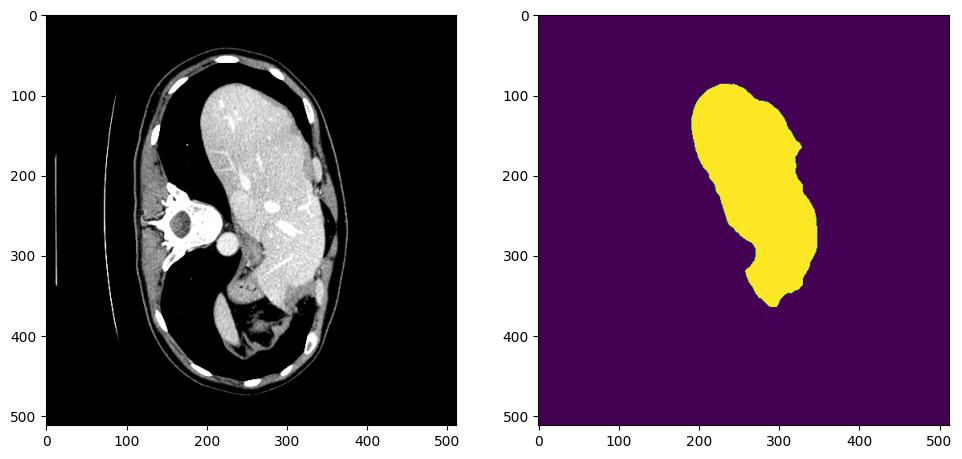

In [ ]:
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img[0,:, :, -40].detach().cpu(), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(test_ds[0]["label"][0,:, :, -40].detach().cpu())
#plt.subplot(1, 3, 3)

#plt.imshow(label[0,:, :,-40].detach().cpu())
#plt.show()